<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1d_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=0c0f4c71739bc1310677c67bc42ea242dbaf7e6fbf5586e9991a30eb87a74141
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [60]:
import yfinance as yf
daily_data = yf.download(tickers='AAPL', period = '4000d', interval = '1d')
daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-12-05,2.569643,2.590357,2.553214,2.565000,2.202352,583671200
2005-12-06,2.640357,2.672500,2.619643,2.644643,2.270734,857029600
2005-12-07,2.651071,2.659286,2.611429,2.641071,2.267667,679464800
2005-12-08,2.614286,2.648929,2.592857,2.645714,2.271654,790479200
2005-12-09,2.650357,2.663929,2.619643,2.654643,2.279320,555402400
...,...,...,...,...,...,...
2021-10-19,147.009995,149.169998,146.550003,148.759995,148.759995,76378900
2021-10-20,148.699997,149.750000,148.119995,149.259995,149.259995,58418800
2021-10-21,148.809998,149.639999,147.869995,149.479996,149.479996,61421000


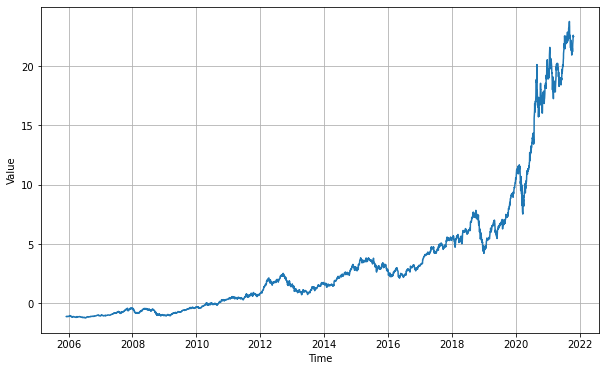

In [61]:
from sklearn.preprocessing import StandardScaler

series = daily_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [62]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [63]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [64]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [65]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 54ms/step - loss: 3.0853 - mae: 3.5538
Epoch 2/100
12/12 [==============================] - 1s 50ms/step - loss: 3.0252 - mae: 3.4939
Epoch 3/100
12/12 [==============================] - 1s 50ms/step - loss: 2.9435 - mae: 3.4125
Epoch 4/100
12/12 [==============================] - 1s 52ms/step - loss: 2.8527 - mae: 3.3217
Epoch 5/100
12/12 [==============================] - 1s 53ms/step - loss: 2.7596 - mae: 3.2292
Epoch 6/100
12/12 [==============================] - 1s 56ms/step - loss: 2.6652 - mae: 3.1361
Epoch 7/100
12/12 [==============================] - 1s 55ms/step - loss: 2.5691 - mae: 3.0419
Epoch 8/100
12/12 [==============================] - 1s 54ms/step - loss: 2.4734 - mae: 2.9482
Epoch 9/100
12/12 [==============================] - 1s 54ms/step - loss: 2.3742 - mae: 2.8505
Epoch 10/100
12/12 [=======================

(1e-08, 0.0001, 0.0, 25.0)

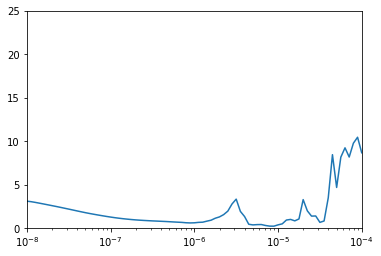

In [67]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 25])

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
30/30 [==============================] - 5s 35ms/step - loss: 0.9224 - mae: 1.3324
Epoch 2/150
30/30 [==============================] - 1s 35ms/step - loss: 0.4214 - mae: 0.7925
Epoch 3/150
30/30 [==============================] - 1s 36ms/step - loss: 0.2789 - mae: 0.6124
Epoch 4/150
30/30 [==============================] - 1s 35ms/step - loss: 0.2161 - mae: 0.5355
Epoch 5/150
30/30 [==============================] - 1s 35ms/step - loss: 0.1041 - mae: 0.3601
Epoch 6/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0809 - mae: 0.3067
Epoch 7/150
30/30 [==============================] - 1s 35ms/step - loss: 0.0499 - mae: 0.2290
Epoch 8/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0323 - mae: 0.1669
Epoch 9/150
30/30 [==============================] - 1s 35ms/step - loss: 0.0334 - mae: 0.1743
Epoch 10/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0402 - mae: 0.2054
Epoch 11/150
30/30 [=============================

In [69]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

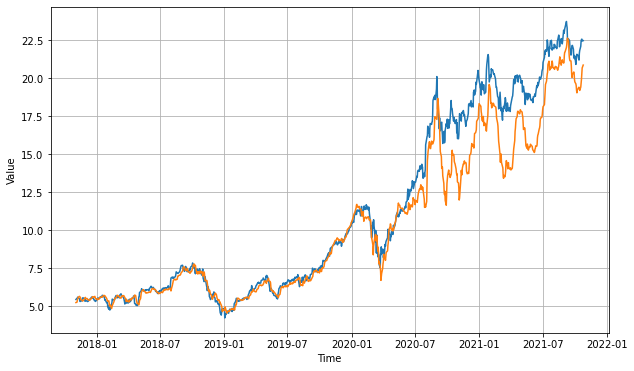

In [70]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03